In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc

!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import warnings
warnings.simplefilter('ignore', FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
train_df = pd.read_csv('/kaggle/input/data-split/train_split/10/train_october.csv')
test_df = pd.read_csv('/kaggle/input/data-split/train_split/10/test_october.csv')

In [3]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

# Chuẩn hóa

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Chọn feature

In [5]:
top_features =  ['EWSS', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SSHF', 'TCLW', 'TCW', 'U250', 'U850', 'V250', 'V850', 'B11B', 'B14B', 'I4B', 'IRB']

In [6]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [7]:
models_info = [
    ("Tháng 10", X_train_scaled, y_train, X_test_scaled, y_test),
]

# Hàm bổ trợ

In [8]:
# ——— Utility functions ———
def softmax(Z):
    # Ensure Z is a numpy array of shape (n_samples, n_classes)
    Z_arr = Z.values if hasattr(Z, "values") else np.array(Z)
    # 1) subtract the max for numerical stability
    #    max_per_row: shape (n_samples,)
    max_per_row = np.max(Z_arr, axis=1)
    #    reshape to (n_samples, 1) so broadcasting works
    max_per_row = max_per_row.reshape(-1, 1)
    # 2) exponentiate
    expZ = np.exp(Z_arr - max_per_row)
    # 3) sum per row, then reshape to (n_samples, 1)
    sum_per_row = np.sum(expZ, axis=1).reshape(-1, 1)
    # 4) divide
    return expZ / sum_per_row

In [9]:
def pack(W1, b1, W2, b2):
    """
    Flatten and concatenate parameters, handling pandas DataFrame/Series inputs.
    """
    # Convert DataFrame/Series to numpy arrays
    W1_arr = W1.values if isinstance(W1, pd.DataFrame) else np.array(W1)
    b1_arr = b1.values if isinstance(b1, (pd.Series, pd.DataFrame)) else np.array(b1)
    W2_arr = W2.values if isinstance(W2, pd.DataFrame) else np.array(W2)
    b2_arr = b2.values if isinstance(b2, (pd.Series, pd.DataFrame)) else np.array(b2)
    # Flatten and concatenate
    return np.hstack([
        W1_arr.ravel(),
        b1_arr.ravel(),
        W2_arr.ravel(),
        b2_arr.ravel()
    ])

In [10]:
def unpack(p, input_dim, hidden_dim, output_dim):
    idx = 0
    W1 = p[idx:idx + hidden_dim*input_dim].reshape(hidden_dim, input_dim)
    idx += hidden_dim*input_dim
    b1 = p[idx:idx + hidden_dim]
    idx += hidden_dim
    W2 = p[idx:idx + output_dim*hidden_dim].reshape(output_dim, hidden_dim)
    idx += output_dim*hidden_dim
    b2 = p[idx:idx + output_dim]
    return W1, b1, W2, b2

In [11]:
def trainscg(loss_grad_func, x0, epochs=8, **lg_kwargs):
    sigma0, lambd = 1e-6, 1e-6
    x = x0.copy()
    f, g = loss_grad_func(x, **lg_kwargs)
    d = -g
    errors = [f]
    for epoch in range(epochs):
        mu = d.dot(d)
        sigma = sigma0 / np.sqrt(mu) if mu > 0 else sigma0
        _, g1 = loss_grad_func(x + sigma*d, **lg_kwargs)
        s = (g1 - g) / sigma
        delta = d.dot(s)
        if delta <= 0:
            delta = lambd * mu
            lambd -= delta / mu
        alpha = -d.dot(g) / (delta + lambd*mu)
        x_new = x + alpha*d
        f_new, g_new = loss_grad_func(x_new, **lg_kwargs)
        Delta = 2*(f - f_new) / (alpha * d.dot(g))
        if Delta >= 0:
            x, f, g = x_new, f_new, g_new
            lambd *= max(1/3, 1 - (2*Delta - 1)**3)
            beta = (g.dot(g) - g.dot(g_new)) / (d.dot(g))
            d = -g + beta*d
        else:
            lambd += mu * (1 - Delta)
        errors.append(f)
    return x, errors

In [12]:
def loss_grad_factory(X, Y_oh, input_dim, hidden_dim, output_dim):
    def loss_and_grad(p):
        W1, b1, W2, b2 = unpack(p, input_dim, hidden_dim, output_dim)
        m = X.shape[0]
        Z1 = X.dot(W1.T) + b1
        A1 = np.tanh(Z1)
        Z2 = A1.dot(W2.T) + b2
        A2 = softmax(Z2)
        loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
        dZ2 = (A2 - Y_oh) / m
        dW2 = dZ2.T.dot(A1)
        db2 = dZ2.sum(axis=0)
        dA1 = dZ2.dot(W2)
        dZ1 = dA1 * (1 - np.tanh(Z1)**2)
        dW1 = dZ1.T.dot(X)
        db1 = dZ1.sum(axis=0)
        return loss, pack(dW1, db1, dW2, db2)
    return loss_and_grad


In [13]:
param_grid = {'hidden_dim': [10, 20, 50, 100, 150, 17, 25, 34, 50, 68, 85]}

In [14]:
def train_and_evaluate_model(name, X_trval, y_trval, X_test, y_test, top_features=None, param_grid=param_grid):
    print(f"\n=== Dataset: {name} ===")

    if top_features is not None:
        X_trval = X_trval[top_features]
        X_test = X_test[top_features]

    X_train, X_val, y_train, y_val = train_test_split(
        X_trval, y_trval, test_size=0.2, random_state=42
    )

    # One-hot encode
    encoder = OneHotEncoder(sparse=False, categories='auto')
    Y_train_oh = encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
    Y_val_oh   = encoder.transform(y_val.to_numpy().reshape(-1, 1))

    input_dim  = X_train.shape[1]
    output_dim = Y_train_oh.shape[1]

    best_h, best_loss = None, np.inf
    for h in param_grid['hidden_dim']:
        param_size = h*input_dim + h + output_dim*h + output_dim
        init_p = 0.01 * np.random.randn(param_size)
        lg = loss_grad_factory(X_train, Y_train_oh, input_dim, h, output_dim)
        opt_p, _ = trainscg(lg, init_p, epochs=8)

        W1, b1, W2, b2 = unpack(opt_p, input_dim, h, output_dim)
        Z1_val = X_val @ W1.T + b1
        A1_val = np.tanh(Z1_val)
        Z2_val = A1_val @ W2.T + b2
        A2_val = softmax(Z2_val)

        val_loss = -np.mean(np.sum(Y_val_oh * np.log(A2_val + 1e-12), axis=1))
        print(f" hidden_dim={h:<3} → val loss = {val_loss:.6f}")
        if val_loss < best_loss:
            best_loss, best_h = val_loss, h

    print(f"⇒ Best hidden_dim = {best_h}, validation loss = {best_loss:.6f}")

    # retrain on full train+val
    X_full = np.vstack([X_train, X_val])
    y_full = np.hstack([y_train, y_val])
    Y_full_oh = encoder.fit_transform(y_full.reshape(-1,1))

    param_size = best_h*input_dim + best_h + output_dim*best_h + output_dim
    init_p_full = 0.01 * np.random.randn(param_size)
    lg_full = loss_grad_factory(X_full, Y_full_oh, input_dim, best_h, output_dim)
    opt_p_full, _ = trainscg(lg_full, init_p_full, epochs=8)

    # evaluate
    W1f, b1f, W2f, b2f = unpack(opt_p_full, input_dim, best_h, output_dim)
    A1_test = np.tanh(X_test @ W1f.T + b1f)
    probs_test = softmax(A1_test @ W2f.T + b2f)
    preds_test = np.argmax(probs_test, axis=1)

    print("Test classification report:")
    print(classification_report(y_test, preds_test))
    cm = confusion_matrix(y_test, preds_test)
    print("Test confusion matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – hidden_dim={best_h}")
    plt.show()



=== Dataset: Tháng 10 (All Features) ===
 hidden_dim=10  → val loss = 0.691186
 hidden_dim=20  → val loss = 0.694683
 hidden_dim=50  → val loss = 0.688594
 hidden_dim=100 → val loss = 0.696378
 hidden_dim=150 → val loss = 0.692465
 hidden_dim=17  → val loss = 0.695625
 hidden_dim=25  → val loss = 0.689948
 hidden_dim=34  → val loss = 0.690745
 hidden_dim=50  → val loss = 0.697723
 hidden_dim=68  → val loss = 0.691544
 hidden_dim=85  → val loss = 0.693772
⇒ Best hidden_dim = 50, validation loss = 0.688594
Test classification report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87     68556
           1       1.00      0.01      0.02     20763

    accuracy                           0.77     89319
   macro avg       0.88      0.50      0.44     89319
weighted avg       0.82      0.77      0.67     89319

Test confusion matrix:
 [[68556     0]
 [20595   168]]


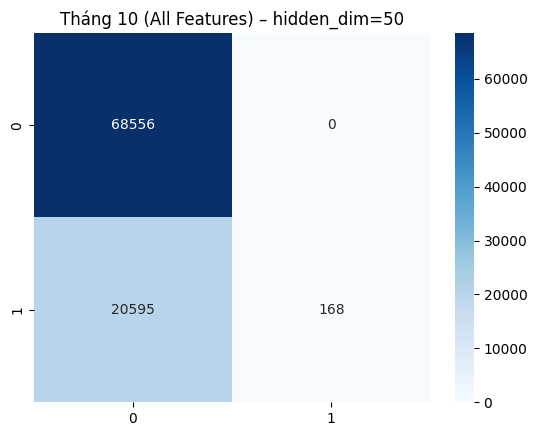


=== Dataset: Tháng 10 (Top Features) ===
 hidden_dim=10  → val loss = 0.697105
 hidden_dim=20  → val loss = 0.697742
 hidden_dim=50  → val loss = 0.687243
 hidden_dim=100 → val loss = 0.697193
 hidden_dim=150 → val loss = 0.695812
 hidden_dim=17  → val loss = 0.692181
 hidden_dim=25  → val loss = 0.694094
 hidden_dim=34  → val loss = 0.697304
 hidden_dim=50  → val loss = 0.689587
 hidden_dim=68  → val loss = 0.695189
 hidden_dim=85  → val loss = 0.696269
⇒ Best hidden_dim = 50, validation loss = 0.687243
Test classification report:
              precision    recall  f1-score   support

           0       0.91      0.12      0.21     68556
           1       0.25      0.96      0.40     20763

    accuracy                           0.31     89319
   macro avg       0.58      0.54      0.30     89319
weighted avg       0.76      0.31      0.25     89319

Test confusion matrix:
 [[ 8150 60406]
 [  780 19983]]


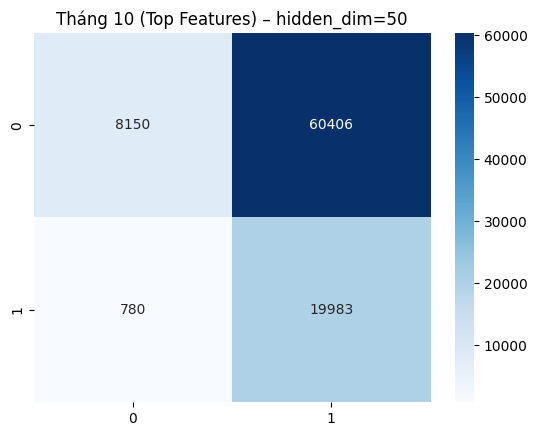

In [15]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    
    train_and_evaluate_model(name + " (All Features)", X_trval, y_trval, X_test, y_test)

    train_and_evaluate_model(name + " (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features)

# Oversampling

##  SMOTE

In [16]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [17]:
models_info = [
    ("Tháng 10 smote", X_train_scaled, y_sm, X_test_scaled, y_test),
]


=== Dataset: Tháng 10 smote (All Features) ===
 hidden_dim=10  → val loss = 0.693333
 hidden_dim=20  → val loss = 0.715526


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=50  → val loss = 5.907438
 hidden_dim=100 → val loss = 0.694889
 hidden_dim=150 → val loss = 0.695556
 hidden_dim=17  → val loss = 5.903998
 hidden_dim=25  → val loss = 0.693446
 hidden_dim=34  → val loss = 0.693371


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))


 hidden_dim=50  → val loss = 5.908689


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=68  → val loss = 5.909002
 hidden_dim=85  → val loss = 0.693660
⇒ Best hidden_dim = 10, validation loss = 0.693333


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/tmp/ipykernel_13/2642452818.py:5: RuntimeWarning: invalid value encountered in add
  Z1 = X.dot(W1.T) + b1
/tmp/ipykernel_13/2642452818.py:6: RuntimeWarning: invalid value encountered in tanh
  A1 = np.tanh(Z1)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:14: RuntimeWarning: invalid value encountered in tanh
  dZ1 = dA1 * (1 - np.tanh(Z1)**2)


Test classification report:
              precision    recall  f1-score   support

           0       0.72      0.69      0.70     68556
           1       0.11      0.13      0.12     20763

    accuracy                           0.56     89319
   macro avg       0.42      0.41      0.41     89319
weighted avg       0.58      0.56      0.57     89319

Test confusion matrix:
 [[47121 21435]
 [18110  2653]]


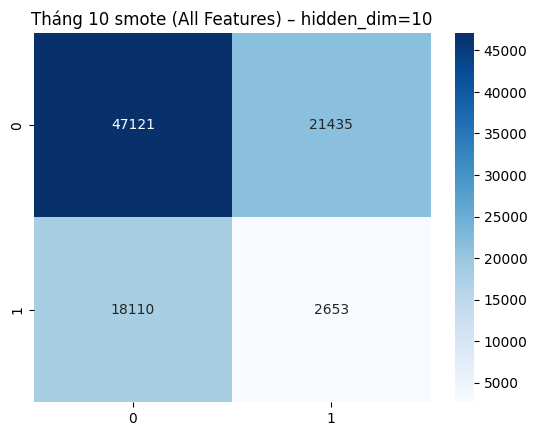


=== Dataset: Tháng 10 smote (Top Features) ===


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=10  → val loss = 5.445128
 hidden_dim=20  → val loss = 0.693704


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=50  → val loss = 22.184955
 hidden_dim=100 → val loss = 0.694227
 hidden_dim=150 → val loss = 0.693378
 hidden_dim=17  → val loss = 5.443877
 hidden_dim=25  → val loss = 0.694332


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=34  → val loss = 5.442938


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=50  → val loss = 5.445441
 hidden_dim=68  → val loss = 0.693468
 hidden_dim=85  → val loss = 0.693364
⇒ Best hidden_dim = 85, validation loss = 0.693364
Test classification report:
              precision    recall  f1-score   support

           0       0.94      0.28      0.43     68556
           1       0.28      0.94      0.43     20763

    accuracy                           0.43     89319
   macro avg       0.61      0.61      0.43     89319
weighted avg       0.78      0.43      0.43     89319

Test confusion matrix:
 [[19305 49251]
 [ 1310 19453]]


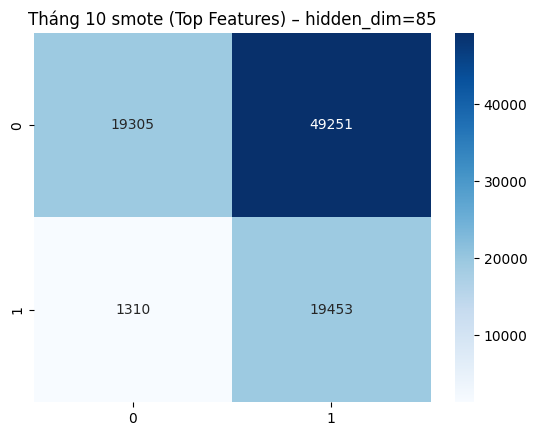

In [18]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    
    train_and_evaluate_model(name + " (All Features)", X_trval, y_trval, X_test, y_test)

    train_and_evaluate_model(name + " (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features)

## SMOTE ENN

In [19]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [20]:
models_info = [
    ("Tháng 10 smote", X_train_scaled, y_smenn, X_test_scaled, y_test),
]


=== Dataset: Tháng 10 smote (All Features) ===
 hidden_dim=10  → val loss = 4.730864
 hidden_dim=20  → val loss = 4.728511
 hidden_dim=50  → val loss = 0.693109
 hidden_dim=100 → val loss = 0.695334
 hidden_dim=150 → val loss = 0.694623
 hidden_dim=17  → val loss = 0.693401
 hidden_dim=25  → val loss = 0.693569


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=34  → val loss = 13.711387
 hidden_dim=50  → val loss = 0.766681
 hidden_dim=68  → val loss = 0.693162
 hidden_dim=85  → val loss = 0.694568
⇒ Best hidden_dim = 50, validation loss = 0.693109
Test classification report:
              precision    recall  f1-score   support

           0       0.85      0.32      0.47     68556
           1       0.27      0.82      0.40     20763

    accuracy                           0.44     89319
   macro avg       0.56      0.57      0.44     89319
weighted avg       0.72      0.44      0.45     89319

Test confusion matrix:
 [[22184 46372]
 [ 3807 16956]]


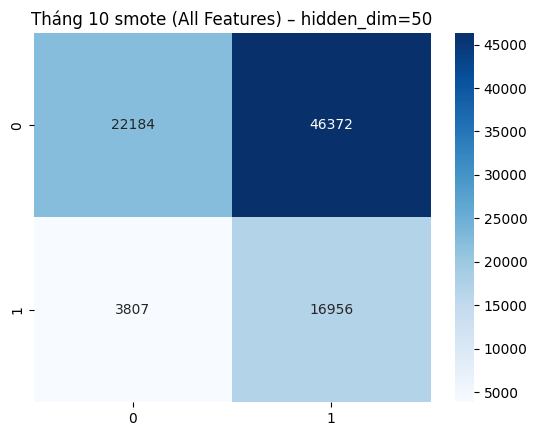


=== Dataset: Tháng 10 smote (Top Features) ===


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=10  → val loss = 4.150046
 hidden_dim=20  → val loss = 0.693325
 hidden_dim=50  → val loss = 0.694319


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=100 → val loss = 23.482544
 hidden_dim=150 → val loss = 0.695278


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=17  → val loss = 4.148477
 hidden_dim=25  → val loss = 4.149653


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=34  → val loss = 4.151222
 hidden_dim=50  → val loss = 0.694310
 hidden_dim=68  → val loss = 0.694726
 hidden_dim=85  → val loss = 0.695813
⇒ Best hidden_dim = 20, validation loss = 0.693325
Test classification report:
              precision    recall  f1-score   support

           0       0.94      0.28      0.43     68556
           1       0.28      0.94      0.43     20763

    accuracy                           0.43     89319
   macro avg       0.61      0.61      0.43     89319
weighted avg       0.78      0.43      0.43     89319

Test confusion matrix:
 [[19327 49229]
 [ 1311 19452]]


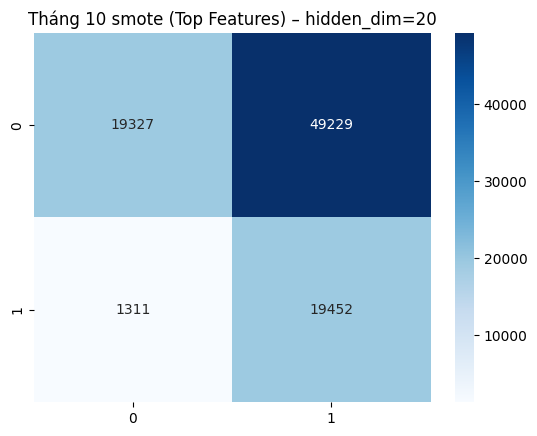

In [21]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    
    train_and_evaluate_model(name + " (All Features)", X_trval, y_trval, X_test, y_test)

    train_and_evaluate_model(name + " (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features)